In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_init = pd.read_csv("ozon_product_queries_details.csv")


In [156]:
def eda(df):
    df_eda = df.copy()
    df_eda = df_eda.drop(columns=["loaded_at"])

    queries_count = (
        (
            df_eda[["date", "sku", "query"]]
            .groupby(["date", "sku"])
            .count()
            .sort_values(by=["query"], ascending=False)
        )
        .reset_index()
        .rename(columns={"query": "queries_count"})
    )

    def queries_freq_categ(x):
        if x > 40:
            return "high"
        elif x > 10:
            return "med"
        else:
            return "low"

    df_eda = df_eda.merge(queries_count, on=["date", "sku"], how="inner")
    df_eda["sku_freq_category"] = df_eda["queries_count"].apply(queries_freq_categ)
    df_eda["query_len"] = df_eda["query"].astype(str).str.len()

    df_eda["has_order"] = (df_eda["order_count"] > 0).astype(int)
    df_eda["has_gmv"] = (df_eda["gmv"] > 0).astype(int)

    eda_chart_df = df_eda.copy()
    agg_method = {
        "view_conversion": lambda x: (x > 0).sum(),
        "unique_search_users": "sum",
        "unique_view_users": "sum",
        "position": "median",
        "query_len": "median",
    }

    eda_chart_df = (
        eda_chart_df.groupby(["date", "sku_freq_category"])
        .agg(agg_method)
        .round(2)
        .reset_index()
    )
    eda_chart_df["search_views_%"] = (
        (eda_chart_df["unique_view_users"] / eda_chart_df["unique_search_users"])
        * 100
    ).round(2)
    eda_chart_df["conversion_case_%"] = (
        (eda_chart_df["view_conversion"] / eda_chart_df["unique_view_users"]) * 100
    ).round(2)

    return eda_chart_df, df_eda

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14794 entries, 0 to 14793
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 14794 non-null  object 
 1   sku                  14794 non-null  int64  
 2   currency             14794 non-null  object 
 3   gmv                  14794 non-null  float64
 4   order_count          14794 non-null  int64  
 5   position             14794 non-null  int64  
 6   query                14794 non-null  object 
 7   view_conversion      14794 non-null  float64
 8   unique_search_users  14794 non-null  int64  
 9   unique_view_users    14794 non-null  int64  
 10  queries_count        14794 non-null  int64  
 11  sku_freq_category    14794 non-null  object 
 12  query_len            14794 non-null  int64  
 13  has_order            14794 non-null  int64  
 14  has_gmv              14794 non-null  int64  
dtypes: float64(2), int64(9), object(4)
m

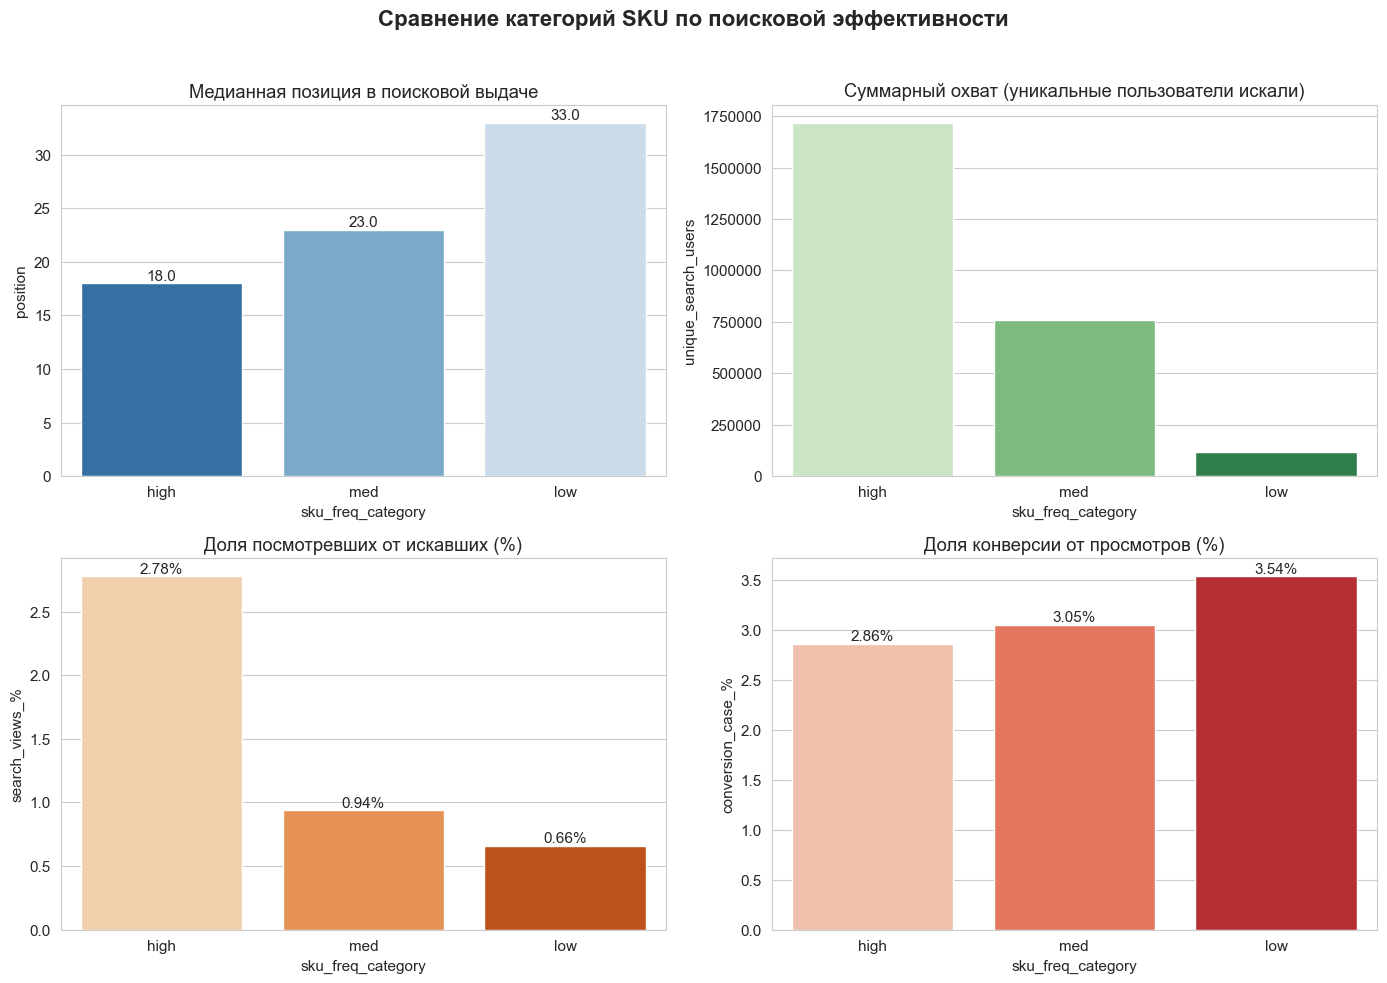

In [157]:
def eda_plot():
    eda_chart_df, df_eda = eda(df_init)
    print(df_eda.info())
    print(df_eda.describe())

    category_order = ["high", "med", "low"]
    eda_chart_df["sku_freq_category"] = pd.Categorical(
        eda_chart_df["sku_freq_category"], categories=category_order, ordered=True
    )
    eda_chart_df = eda_chart_df.sort_values("sku_freq_category")

    sns.set_style("whitegrid")
    plt.rcParams.update({"font.size": 11})

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(
        "Сравнение категорий SKU по поисковой эффективности",
        fontsize=16,
        weight="bold",
    )

    sns.barplot(
        data=eda_chart_df,
        x="sku_freq_category",
        y="position",
        hue='sku_freq_category',
        ax=axes[0, 0],
        palette="Blues_r",
        legend=False,
    )
    axes[0, 0].set_title("Медианная позиция в поисковой выдаче")
    for c in axes[0, 0].containers:
        axes[0, 0].bar_label(c, fmt="%.1f")

    sns.barplot(
        data=eda_chart_df,
        x="sku_freq_category",
        y="unique_search_users",
        hue='sku_freq_category',
        ax=axes[0, 1],
        palette="Greens",
        legend=False,
    )
    axes[0, 1].set_title("Суммарный охват (уникальные пользователи искали)")
    axes[0, 1].ticklabel_format(style="plain", axis="y")

    sns.barplot(
        data=eda_chart_df,
        x="sku_freq_category",
        y="search_views_%",
        hue='sku_freq_category',
        ax=axes[1, 0],
        palette="Oranges",
        legend=False,
    )
    axes[1, 0].set_title("Доля посмотревших от искавших (%)")
    for c in axes[1, 0].containers:
        axes[1, 0].bar_label(c, fmt="%.2f%%")

    sns.barplot(
        data=eda_chart_df,
        x="sku_freq_category",
        y="conversion_case_%",
        hue='sku_freq_category',
        ax=axes[1, 1],
        palette="Reds",
        legend=False,
    )
    axes[1, 1].set_title("Доля конверсии от просмотров (%)")
    for c in axes[1, 1].containers:
        axes[1, 1].bar_label(c, fmt="%.2f%%")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

eda_plot()

In [158]:
def normalize_query(query):
    q = str(query).lower().strip()
    q = re.sub(r"[^\w\s]", " ", q)
    q = re.sub(r"\s+", " ", q)
    return q

In [159]:
morph = pymorphy3.MorphAnalyzer(lang="ru")

def lemmatize_query(query):
    words = normalize_query(query).split()
    lemmas = []
    for word in words:
        parsed = morph.parse(word)
        if parsed:
            lemma = parsed[0].normal_form
            lemmas.append(lemma)
        else:
            lemmas.append(word)
    return " ".join(lemmas)

In [160]:
def cluster_similar_queries():
    _, df_sim = eda(df_init)

    df_sim["query_lemmatized"] = df_sim["query"].apply(lemmatize_query)

    df_sim["word_signature"] = df_sim["query_lemmatized"].apply(
        lambda x: " ".join(sorted(x.split()))
    )

    signature_to_id = {
        sig: i for i, sig in enumerate(df_sim["word_signature"].unique())
    }
    df_sim["query_cluster_id"] = df_sim["word_signature"].map(signature_to_id)

    df_sim["query_cluster_repr"] = df_sim.groupby("word_signature")[
        "query"
    ].transform(lambda g: min(g, key=lambda x: len(str(x))))

    df_sim = df_sim.drop(
        columns=["word_signature", "query_lemmatized", "query", "query_cluster_id"]
    )

    agg_method = {
        "gmv": "sum",
        "order_count": "sum",
        "position": "mean",
        "view_conversion": "mean",
        "unique_search_users": "sum",
        "unique_view_users": "sum",
        "query_len": "mean",
        "has_order": "max",
        "has_gmv": "max",
    }
    df_sim = (
        df_sim.groupby(
            [
                "date",
                "sku",
                "currency",
                "queries_count",
                "sku_freq_category",
                "query_cluster_repr",
            ]
        )
        .agg(agg_method)
        .round(2)
        .reset_index()
    )

    return df_sim

Baseline: Рекомендация эффективных запросов

In [161]:
def baseline_recommendations(top_n=5):
    df_sim = cluster_similar_queries()

    df_sim["score_seo"] = (
        df_sim["order_count"] * 100
        + df_sim["view_conversion"] * 10
        + (1 / (df_sim["position"] + 1)) * 5
    )

    df_sim["ctr_like"] = df_sim["unique_view_users"] / df_sim[
        "unique_search_users"
    ].replace(0, 1)
    df_sim["score_ad"] = (
        df_sim["queries_count"] * 0.1
        + df_sim["view_conversion"] * 50
        + (1 / (df_sim["position"] + 1)) * 10
        + df_sim["ctr_like"] * 100
    )

    seo_recs = df_sim[
        (df_sim["has_order"] == 1) | (df_sim["view_conversion"] > 0)
    ].copy()
    seo_recs = seo_recs.sort_values(["sku", "score_seo"], ascending=[True, False])
    seo_recs = seo_recs.groupby("sku").head(top_n).reset_index(drop=True)
    seo_recs["recommendation_type"] = "SEO"

    ad_recs = df_sim[
        (df_sim["queries_count"] >= 30)  # высокочастотные запросы юзеров
        & (
            df_sim["unique_view_users"] < df_sim["unique_search_users"] * 0.1
        )  # низкий охват
        & (df_sim["view_conversion"] > 0)  # есть хоть какая-то конверсия
    ].copy()
    ad_recs = ad_recs.sort_values(["sku", "score_ad"], ascending=[True, False])
    ad_recs = ad_recs.groupby("sku").head(top_n).reset_index(drop=True)
    ad_recs["recommendation_type"] = "Ad"

    recommendations = pd.concat([seo_recs, ad_recs], ignore_index=True)

    recommendations = recommendations[
        [
            "sku",
            "query_cluster_repr",
            "recommendation_type",
            "queries_count",
            "position",
            "view_conversion",
            "unique_search_users",
            "unique_view_users",
            "order_count",
            "gmv",
            "score_seo",
            "score_ad",
        ]
    ]

    return recommendations

In [162]:
def build_text_profiles():
    df_sim = cluster_similar_queries()

    sku_top_query = df_sim.loc[
        df_sim.groupby("sku")["unique_search_users"].idxmax()
    ][["sku", "query_cluster_repr"]].reset_index(drop=True)

    vectorizer = TfidfVectorizer(
        stop_words=None, ngram_range=(1, 2), max_features=1000
    )
    tfidf_matrix = vectorizer.fit_transform(sku_top_query["query_cluster_repr"])

    return sku_top_query, tfidf_matrix, vectorizer

Content-Based Filtering (CBF)

In [163]:
def get_similar_skus(target_sku, top_n=5):
    sku_names, tfidf_matrix, _ = build_text_profiles()

    target_idx = sku_names[sku_names["sku"] == target_sku].index[0]
    target_vec = tfidf_matrix[target_idx]

    similarities = cosine_similarity(target_vec, tfidf_matrix).flatten()
    sku_names["similarity"] = similarities

    similar = (
        sku_names[sku_names["sku"] != target_sku]
        .sort_values("similarity", ascending=False)
        .head(top_n)
    )

    return similar[["sku", "query_cluster_repr", "similarity"]]

Collaborative Filtering (CF)

In [164]:
def build_interaction_matrix():
    df_sim = cluster_similar_queries()
    df_sim = df_sim[df_sim["position"] > 0].copy()
    df_sim["relevance"] = 1 / (df_sim["position"] + 1)

    interaction_matrix = df_sim.pivot_table(
        index="query_cluster_repr", columns="sku", values="relevance", fill_value=0
    )

    return interaction_matrix

In [165]:
def get_similar_skus_collab(target_sku, top_n=5):
    interaction_matrix = build_interaction_matrix()

    target_vec = interaction_matrix[target_sku].values.reshape(1, -1)
    all_vecs = interaction_matrix.values.T  # транспонируем, чтобы строки были SKU
    similarities = cosine_similarity(target_vec, all_vecs).flatten()

    sim_df = pd.DataFrame(
        {"sku": interaction_matrix.columns, "similarity": similarities}
    )

    similar = (
        sim_df[sim_df["sku"] != target_sku]
        .sort_values("similarity", ascending=False)
        .head(top_n)
    )

    return similar

Hybrid Model (CBF + CF)

In [166]:
def get_full_cbf_similarity():
    sku_names, tfidf_matrix, _ = build_text_profiles()
    similarity_matrix = cosine_similarity(tfidf_matrix)

    return pd.DataFrame(
        similarity_matrix, index=sku_names["sku"], columns=sku_names["sku"]
    )

In [167]:
def get_full_cf_similarity():
    interaction_matrix = build_interaction_matrix()

    item_vectors = interaction_matrix.T # так же, чтобы строки были SKU
    similarity_matrix = cosine_similarity(item_vectors)

    return pd.DataFrame(
        similarity_matrix, index=item_vectors.index, columns=item_vectors.index
    )

In [168]:
def get_hybrid_recommendations(target_sku, top_n=5, weight_cbf=0.6, weight_cf=0.4):
    cbf_sim = get_full_cbf_similarity()
    cf_sim = get_full_cf_similarity()

    common_skus = cbf_sim.index.intersection(cf_sim.index)
    cbf_scores = cbf_sim.loc[target_sku, common_skus]
    cf_scores = cf_sim.loc[target_sku, common_skus]

    hybrid_scores = weight_cbf * cbf_scores + weight_cf * cf_scores

    hybrid_scores = hybrid_scores.drop(target_sku, errors="ignore")
    top_skus = hybrid_scores.sort_values(ascending=False).head(top_n)

    res = pd.DataFrame(
        {
            "sku": top_skus.index,
            "hybrid_similarity": top_skus.values,
            "cbf_similarity": cbf_scores[top_skus.index].values,
            "cf_similarity": cf_scores[top_skus.index].values,
        }
    )

    return res

Model evaluation

In [169]:
def evaluate_all_models(top_k=5):
    df_sim = cluster_similar_queries()
    cbf_sim = get_full_cbf_similarity()
    cf_sim = get_full_cf_similarity()

    common_skus = cbf_sim.index.intersection(cf_sim.index)
    results = []

    query_to_relevant = {}
    sales_queries = df_sim[df_sim['order_count'] > 0]
    for query, group in sales_queries.groupby('query_cluster_repr'):
        skus = set(group['sku'].unique())
        query_to_relevant[query] = skus

    for sku in common_skus:
        cbf_scores = cbf_sim.loc[sku, common_skus].drop(sku, errors='ignore')
        cbf_recs = set(cbf_scores.nlargest(top_k).index.tolist())

        cf_scores = cf_sim.loc[sku, common_skus].drop(sku, errors='ignore')
        cf_recs = set(cf_scores.nlargest(top_k).index.tolist())

        hybrid_scores = 0.6 * cbf_scores + 0.4 * cf_scores
        hybrid_recs = set(hybrid_scores.nlargest(top_k).index.tolist())

        relevant_in_queries = [
            relevant for q, relevant in query_to_relevant.items() if sku in relevant
        ]

        all_relevant = set()
        for i in relevant_in_queries:
            all_relevant.update(i)
        all_relevant.discard(sku)

        def precision_at_k(recommended):
            hits = len(recommended & all_relevant)
            return hits / min(top_k, len(recommended))

        results.append({
            'sku': sku,
            'cbf_precision': precision_at_k(cbf_recs),
            'cf_precision': precision_at_k(cf_recs),
            'hybrid_precision': precision_at_k(hybrid_recs)
        })

    results_df = pd.DataFrame(results)

    summary = {
        'Модель': ['Content-Based (CBF)', 'Collaborative (CF)', 'Hybrid (CBF+CF)'],
        'Precision@K': [
            results_df['cbf_precision'].mean(),
            results_df['cf_precision'].mean(),
            results_df['hybrid_precision'].mean()
        ]
    }

    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.sort_values('Precision@K', ascending=False).reset_index(drop=True)

    print(summary_df.to_string(index=False, float_format="%.4f"))
    best_model = summary_df.iloc[0]['Модель']
    print(f"\n Лучшая модель: {best_model}")

    return summary_df

evaluate_all_models()

             Модель  Precision@K
    Hybrid (CBF+CF)       0.0376
 Collaborative (CF)       0.0352
Content-Based (CBF)       0.0243

 Лучшая модель: Hybrid (CBF+CF)


,Модель,Precision@K
0,Hybrid (CBF+CF),0.037573
1,Collaborative (CF),0.035225
2,Content-Based (CBF),0.024266


Вывод:
Наилучшие результаты показала гибридная модель, однако низкая точность связана со спецификой данных и ограниченным жатсетом (продовый существенно больше, следовательно так же больше вероятности возможных комбинаций). Так как релевантным считаются только те sku у которых были продажи или конверсии в общих запросах, а их в разрезе датасета немного (так же была проведена лемматизация запросов, чтобы аггрегировать идентичные по смыслу запросы и уплотнить выборку).

В любом случае гибридная модель показала себя лучше, следовательно будем использовать ее рекомендации.